
#Election Analysis
This notebook is adapted from Wes Mckinley's Python for Data Analysis.

The project analyses 2012 US Federal Election Commission Database which is obtained from https://github.com/wesm/pydata-book/tree/3rd-edition/datasets/fec


We start by importing the libraries and the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget -O P00000001-ALL.csv {"https://raw.githubusercontent.com/wesm/pydata-book/3rd-edition/datasets/fec/P00000001-ALL.csv"}
fec = pd.read_csv('P00000001-ALL.csv')
print(fec.iloc[123])

--2024-05-24 11:32:16--  https://raw.githubusercontent.com/wesm/pydata-book/3rd-edition/datasets/fec/P00000001-ALL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157871393 (151M) [text/plain]
Saving to: ‘P00000001-ALL.csv’

P00000001-ALL.csv   100%[===================>] 150.56M   143MB/s    in 1.1s    

2024-05-24 11:32:23 (143 MB/s) - ‘P00000001-ALL.csv’ saved [157871393/157871393]



<ipython-input-2-3a0ef0bdec0d>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  fec = pd.read_csv('P00000001-ALL.csv')


cmte_id                         C00410118
cand_id                         P20002978
cand_nm                Bachmann, Michelle
contbr_nm                 RAINEY, PATRICK
contbr_city                 WINTER GARDEN
contbr_st                              FL
contbr_zip                    347771599.0
contbr_employer      INTL TRADING COMPANY
contbr_occupation                  BROKER
contb_receipt_amt                   250.0
contb_receipt_dt                20-JUN-11
receipt_desc                          NaN
memo_cd                               NaN
memo_text                             NaN
form_tp                             SA17A
file_num                           736166
Name: 123, dtype: object


We then obtain the set of candidates, and create a dictionary to map them to the corresponding parties, lastly add this mapping as a column.

In [3]:
unique_cands = fec.cand_nm.unique()
print(unique_cands)

['Bachmann, Michelle' 'Romney, Mitt' 'Obama, Barack'
 "Roemer, Charles E. 'Buddy' III" 'Pawlenty, Timothy' 'Johnson, Gary Earl'
 'Paul, Ron' 'Santorum, Rick' 'Cain, Herman' 'Gingrich, Newt'
 'McCotter, Thaddeus G' 'Huntsman, Jon' 'Perry, Rick']


In [4]:
parties = {'Bachmann, Michelle':'Republican',
            'Romney, Mitt':'Republican',
            'Obama, Barack':'Democrat',
            "Roemer, Charles E. 'Buddy' III":'Republican',
            'Pawlenty, Timothy':'Republican',
            'Johnson, Gary Earl':'Republican',
            'Paul, Ron':'Republican',
            'Santorum, Rick':'Republican',
            'Cain, Herman':'Republican',
            'Gingrich, Newt':'Republican',
            'McCotter, Thaddeus G':'Republican',
            'Huntsman, Jon':'Republican',
            'Perry, Rick': 'Republican'}

fec['party']=fec.cand_nm.map(parties)
fec['party'].value_counts()

party
Democrat      593746
Republican    407985
Name: count, dtype: int64

Now, we want to observe information about the contributors of Obama and Romney. We first filter out non-contrtibutors, then obtain the occupations of the top ten contributors.

In [5]:
fec = fec[(fec.contb_receipt_amt>0)]
#filters out 0 contribution

fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])] #main candidates

contributors_analysis = fec.contbr_occupation.value_counts()[:10] #most contributing occupations
print(contributors_analysis)

contbr_occupation
RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: count, dtype: int64


Update null information with Not Provided, self with self-employed, c.e.o. with ceo

In [6]:
occ_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
    'INFORMATION REQUESTED' : 'NOT PROVIDED',
    'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
    'C.E.O.' : 'CEO'
}

emp_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
    'INFORMATION REQUESTED' : 'NOT PROVIDED',
    'SELF' : 'SELF-EMPLOYED',
    'SELF-EMPLOYED' : 'SELF-EMPLOYED'
}

In [7]:
f= lambda x: occ_mapping.get(x,x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

f= lambda x: emp_mapping.get(x,x)
fec.contbr_employer = fec.contbr_employer.map(f)

Apply the mapping and plot the contributor occupation by party.

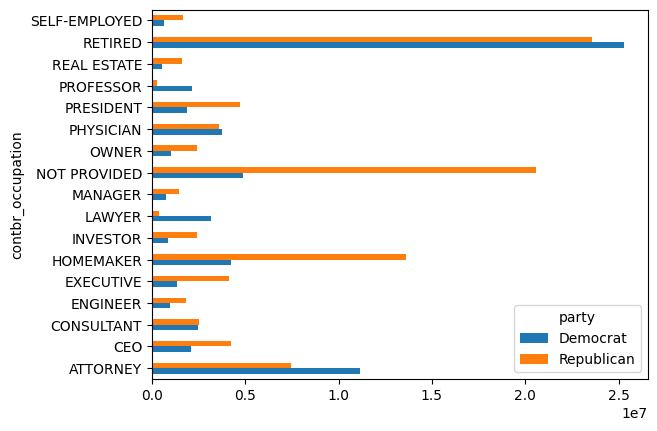

In [8]:
by_occupation = fec.pivot_table('contb_receipt_amt', index = 'contbr_occupation', columns = 'party', aggfunc='sum')
#makes a table for occupations and contribution amount
over_2m = by_occupation[by_occupation.sum(1)>2000000]
over_2m.plot(kind='barh')
plt.show()
#bar graph for contribution by occupation over 2m

Print the top contributors for Obama and Romney

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

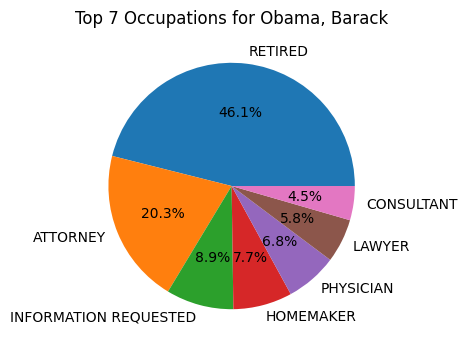

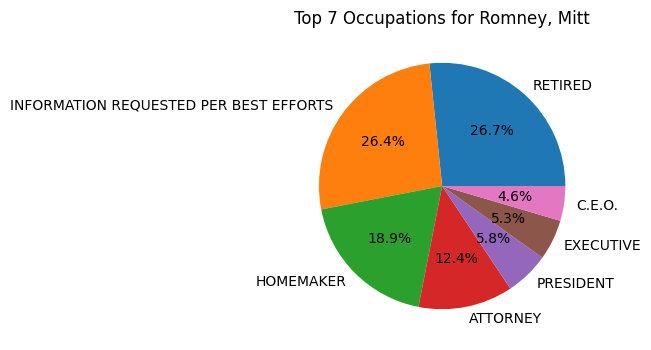

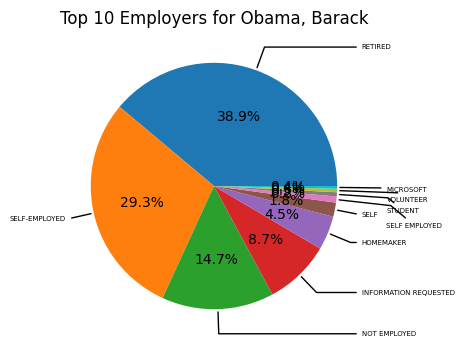

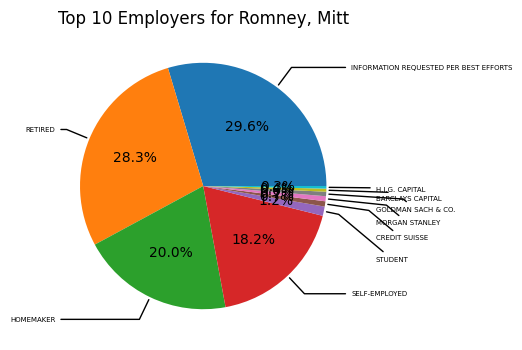

In [75]:
def get_top_amounts(group,key, n=5):
    totals=group.groupby(key)['contb_receipt_amt'].sum()

    return totals.sort_values(ascending = False)[:n]

grouped = fec_mrbo.groupby('cand_nm')

occupation_top7 = grouped.apply(get_top_amounts,'contbr_occupation',n=7)
employer_top10 = grouped.apply(get_top_amounts,'contbr_employer',n=10)
print(occupation_top7)
print(employer_top10)

for cand, occupation in occupation_top7.groupby(level=0):
    plt.figure(figsize=(6,4))
    plt.pie(occupation.values, labels = occupation.index.get_level_values('contbr_occupation'), autopct='%1.1f%%')
    plt.title(f'Top 7 Occupations for {cand}')
    plt.show()

for cand, employer in employer_top10.groupby(level=0):
    plt.figure(figsize=(6,4))
    plt.tight_layout()
    wedges, texts, autotexts = plt.pie(employer.values, autopct='%1.1f%%')
    plt.title(f'Top 10 Employers for {cand}')

    # Adding arrows
    kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        if  employer.values[i]<500000.0:
            xytext = (1.4 * np.sign(x), 2.9 * y)  # Increase distance
            connectionstyle = f"angle,angleA=-40,angleB={ang}"
        else:
            xytext = (1.2 * np.sign(x), 1.2 * y)  # Standard distance
            connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(employer.index.get_level_values('contbr_employer')[i], xy=(x, y), xytext=xytext,
                     horizontalalignment=horizontalalignment,fontsize=5, **kw)
    plt.show()

Create intervals for contributors rounding to the powers of ten

Normalize for each interval to compare the contributors for each interval easier

cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                      318.24         77.00
(1, 10]                  337267.62      29819.66
(10, 100]              20288981.41    1987783.76
(100, 1000]            54798531.46   22363381.69
(1000, 10000]          51753705.67   63942145.42
(10000, 100000]           59100.00      12700.00
(100000, 1000000]       1490683.08          0.00
(1000000, 10000000]     7148839.76          0.00
cand_nm              Obama, Barack  Romney, Mitt
contb_receipt_amt                               
(0, 1]                    0.805182      0.194818
(1, 10]                   0.918767      0.081233
(10, 100]                 0.910769      0.089231
(100, 1000]               0.710176      0.289824
(1000, 10000]             0.447326      0.552674
(10000, 100000]           0.823120      0.176880
(100000, 1000000]         1.000000      0.000000
(1000000, 10000000]       1.000000      0.000000


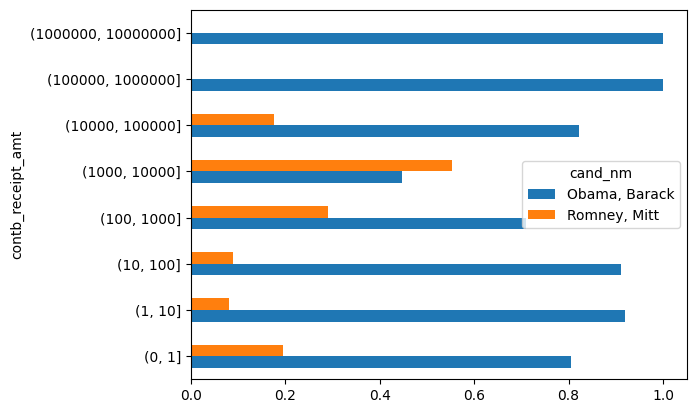

In [11]:
bins = np.array([0,1,10,100,1000,10000,100000,1000000,10000000])

labels = pd.cut(fec_mrbo.contb_receipt_amt,bins)
# print(labels)

grouped = fec_mrbo.groupby(['cand_nm',labels])
grouped.size().unstack()
#groups contributions for intervals

bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
#total amount made in the intervals
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1),axis= 0 )
#percentage in the intervals
print(bucket_sums)
print(normed_sums)

normed_sums.plot(kind='barh')
plt.show()

Group the data for contributors by states, and obtain the percentage values.

cand_nm    Obama, Barack  Romney, Mitt
contbr_st                             
AK              0.765778      0.234222
AL              0.507390      0.492610
AR              0.772902      0.227098
AZ              0.443745      0.556255
CA              0.679498      0.320502
CO              0.585970      0.414030
CT              0.371476      0.628524
DC              0.810113      0.189887
DE              0.802776      0.197224
FL              0.467417      0.532583
GA              0.582670      0.417330
HI              0.876774      0.123226
IA              0.737149      0.262851
ID              0.200608      0.799392
IL              0.819226      0.180774
IN              0.619796      0.380204
KS              0.578359      0.421641
KY              0.517387      0.482613
LA              0.356026      0.643974
MA              0.585323      0.414677
MD              0.747355      0.252645
ME              0.908825      0.091175
MI              0.512175      0.487825
MN              0.855913 

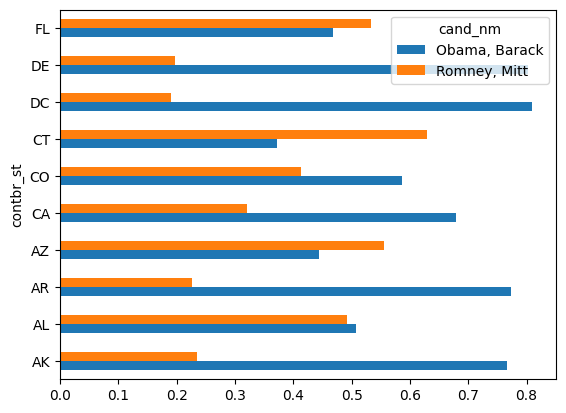

In [12]:
#contribution by states
grouped = fec_mrbo.groupby(['cand_nm','contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1)>100000]
percent = totals.div(totals.sum(1), axis = 0)
print(percent)

percent[:10].plot(kind='barh')
plt.show()